# Aula 06 - Pipeline de Machine Learning

Até o momento implementamos os seguintes algoritmos: 

- **KNN**: supervisionado, para _classificação_
- **K-means**: não-supervisionado, para _clusterização_

Estes algoritmos são simples para serem implementados, mas podemos utilizar bibliotecas prontas, como o `sklearn` (veja [o site](https://scikit-learn.org/stable/)), focando nosso trabalho na preparação e uso dos dados, bem como nas interpretações dos resultados/modelos. 

Nesta aula vamos explorar um pouco mais os métodos vistos, mas utilizando o **sklearn**.

In [29]:
import pandas as pd

from sklearn.model_selection import train_test_split 

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import silhouette_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## K-means com sklearn

### Criando os pontos

In [2]:
import random
random.seed(42)

n_points = 1000                                # Total de pontos
x = [random.random() for i in range(n_points)] # Variável X, com valores aleatórios entre 0 e 1
y = [random.random() for i in range(n_points)] # Variável Y, com valores aleatórios entre 0 e 1
pontos = pd.DataFrame(zip(x, y), columns=["X", "Y"])
pontos.head(5)

,X,Y
0,0.639427,0.099355
1,0.025011,0.685680
2,0.275029,0.544466
3,0.223211,0.977843
4,0.736471,0.358674


In [3]:
pontos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       1000 non-null   float64
 1   Y       1000 non-null   float64
dtypes: float64(2)
memory usage: 15.8 KB


In [4]:
pontos.describe()

,X,Y
count,1000.000000,1000.000000
mean,0.512562,0.498946
std,0.287819,0.283422
min,0.000406,0.002836
25%,0.263835,0.260661
50%,0.525294,0.506277
75%,0.756312,0.742115
max,0.999908,0.999595


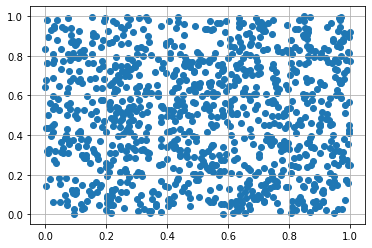

In [5]:
plt.scatter(pontos['X'],pontos['Y'])
plt.grid()
plt.show()

### Escolhendo o melhor valor de K

#### Método do cotovelo

In [6]:
model = KMeans(n_clusters = 2) # K = 2
model.fit(pontos)
model.inertia_

100.92048605575786

In [7]:
model = KMeans(n_clusters = 3) # K = 3
model.fit(pontos)
model.inertia_

63.02995611180231

In [8]:
erros = []
for k in range(2,11):
    model = KMeans(n_clusters = k)
    model.fit(pontos)
    erros.append(model.inertia_)

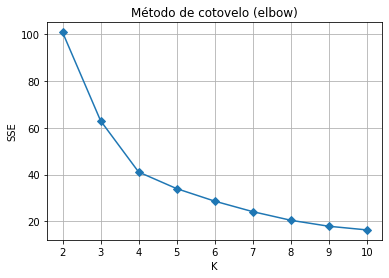

In [9]:
plt.plot(range(2,11), erros, marker= 'D')
plt.grid()
plt.title("Método de cotovelo (elbow)")
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()

#### Método da silhueta

In [10]:
silhuetas = []
for k in range(2,11):
    model = KMeans(n_clusters = k)
    model.fit(pontos)
    coeficiente = silhouette_score(pontos, model.labels_)
    silhuetas.append(coeficiente)

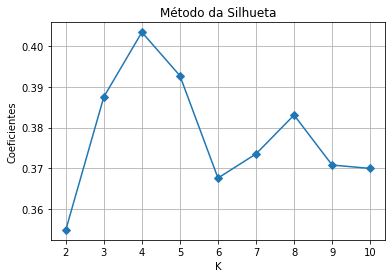

In [11]:
plt.plot(range(2,11), silhuetas, marker= 'D')
plt.grid()
plt.title("Método da Silhueta")
plt.xlabel("K")
plt.ylabel("Coeficientes")
plt.show()

### Outros parâmetros do K-means

Verificar quais são na documentação do k-means, disponível [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [12]:
model = KMeans(n_clusters=4,init="k-means++",max_iter=100,verbose=1)
model.fit(pontos)

Initialization complete
Iteration 0, inertia 53.30121171924283
Iteration 1, inertia 42.890122048195025
Iteration 2, inertia 41.633577357229534
Iteration 3, inertia 41.28249938691597
Iteration 4, inertia 41.19796920339054
Iteration 5, inertia 41.132959432272145
Iteration 6, inertia 41.097957953831
Iteration 7, inertia 41.080125763412376
Iteration 8, inertia 41.07575558567887
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 64.57709429034838
Iteration 1, inertia 48.37295617512757
Iteration 2, inertia 42.63578478740075
Iteration 3, inertia 41.458651554477186
Iteration 4, inertia 41.1996635837006
Iteration 5, inertia 41.111887075330664
Iteration 6, inertia 41.0825226636936
Iteration 7, inertia 41.076622571683764
Converged at iteration 7: center shift 1.8936364909881929e-06 within tolerance 8.150245375551896e-06.
Initialization complete
Iteration 0, inertia 54.97224312136555
Iteration 1, inertia 43.330005380323016
Iteration 2, inertia 42.03363012589

KMeans(max_iter=100, n_clusters=4, verbose=1)

In [13]:
model.n_iter_

8

In [14]:
centroides = model.cluster_centers_
model.cluster_centers_

array([[0.25975482, 0.72385853],
       [0.2525933 , 0.25297555],
       [0.74975766, 0.74035522],
       [0.7604721 , 0.23348607]])

In [15]:
cx = [centroide[0] for centroide in centroides]
cy = [centroide[1] for centroide in centroides]

In [16]:
[centroide[0] for centroide in centroides]

[0.2597548248128848,
 0.2525932980012064,
 0.7497576595058427,
 0.7604721027258075]

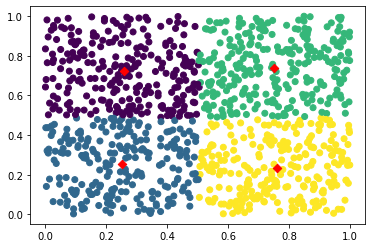

In [17]:
plt.scatter(pontos['X'],pontos['Y'],c=model.labels_)
plt.scatter(cx,cy,c="red",marker="D")

## KNN com sklearn

### Lendo os dados

In [18]:
colunas = ["temporada", "idade", "doenças infantis", "acidente", 
           "cirurgia", "febre", "alcool", "fumo", "horas_sentado", 
           "output"]
df = pd.read_csv("fertility_Diagnosis.txt", header=None) 
df.columns = colunas

In [19]:
df.head()

,temporada,idade,doenças infantis,acidente,cirurgia,febre,alcool,fumo,horas_sentado,output
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,N
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,O
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,N
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,N
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,O


### Ajustando os dados

In [20]:
def troca_label(label):
    if label == "N":
        return 0
    else: 
        return 1

In [21]:
df['output'] = df['output'].apply(troca_label)

### Separando TREINO e TESTE

In [22]:
x = df.drop(columns=['output'])             # dados
y = df['output']                            # rótulos (labels)

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.25,random_state=42)

In [24]:
x_train.shape

(75, 9)

### Criando o modelo

In [49]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

### Avaliando o modelo

In [50]:
y_pred = knn.predict(x_test)

In [51]:
accuracy_score(y_test,y_pred) * 100

88.0

In [52]:
y_score = knn.predict_proba(x_test)

In [53]:
#probabilidade do sétimo elemento pertencer a classe 0?
y_score[6][0]

0.8

In [54]:
roc_auc_score(y_test,y_score[:,-1]) * 100

45.45454545454545

In [55]:
matriz_confusao = confusion_matrix(y_test,y_pred, labels=[0,1])

<AxesSubplot:>

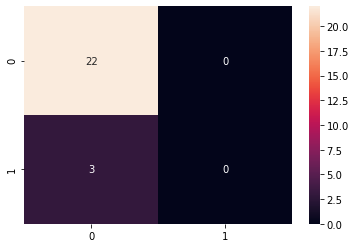

In [56]:
sns.heatmap(matriz_confusao, annot=True)